# kShapeStream Demonstration
This notebook demonstrates use of kShapeStream: a streaming time series clustering algorithm based on the kshape algorithm [1]. The package contains two variants of kShapeStream, both of which use shape based distance (sbd) as the distance metric between time series. kShapeStream assigns a time series to the nearest cluster, while kShapeProbStream assigns it to most likely cluster. Consequently, kShapeProbStream can label some time series as outliers.

The demo data included in this package is a set of 769 voltage events from the open access sunshine data set hosted on the ni4ai platform [2]. The events have no labels and have been found by extracting two seconds of data around changes in voltage exceeding a preset threshold. The events are from a total of two months of data. 

[1] Paparrizos, John, and Luis Gravano. "k-shape: Efficient and accurate clustering of time series." Proceedings of the 2015 ACM SIGMOD International Conference on Management of Data. 2015.

[2] https://ni4ai.org/info

In [1]:
import numpy as np
import pandas as pd
import time
from matplotlib.pyplot import cm

import scipy.signal as sig
from scipy import linalg
from scipy.ndimage.interpolation import shift
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from tabulate import tabulate
from btrdb.utils.timez import ns_delta
from btrdb.utils.timez import ns_delta, to_nanoseconds
from btrdb.utils.timez import ns_to_datetime
from btrdb.utils.general import pointwidth

import importlib

# Plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# Import kShape library
import kshape
importlib.reload(kshape)

import seaborn as sb

## 1. Load Sample Event Data

In [2]:
events = np.load('events_300.npy'); 
[n, m] = np.shape(events)
print(n, ' events of length ', m)

301  events of length  240


## 2.1 kShapeStream

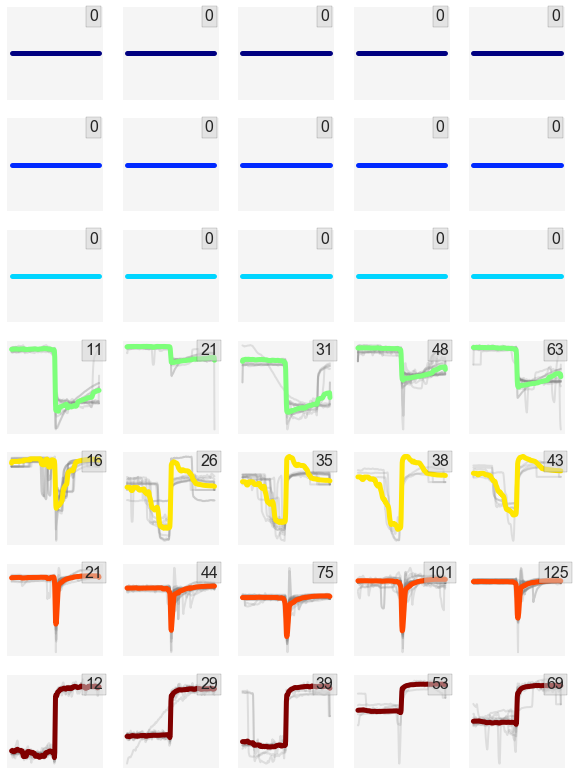

In [8]:
k = 7
kstream = kshape.kShapeStream(k, m)

batch_size = 60; 
n_batches = 5; 

nrows = k; ncols = n_batches
fig, axs = plt.subplots(nrows, ncols); 
fig.set_figheight(nrows*2)
fig.set_figwidth(ncols*2)

for b in range(n_batches):
    # Get batch of data
    batch = events[b*batch_size:(b+1)*batch_size]; 
    # Normalize the data !!!
    batch = kshape.zscore(batch, axis=1, ddof=1); 
    # Cluster
    clusters = kstream.add(batch); 
    kstream.visualize(clusters, batch, axs[:, b]); 

## 2.2 kShapeProbStream

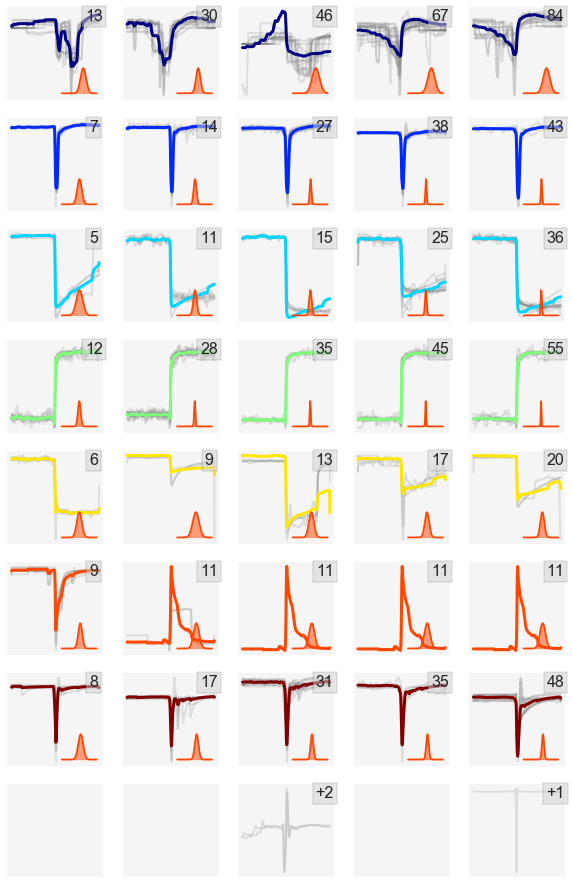

In [6]:
k = 7
kstream = kshape.kShapeProbStream(k, m)

batch_size = 60; 
n_batches = 5; 

nrows = k+1; ncols = n_batches
fig, axs = plt.subplots(nrows, ncols); 
fig.set_figheight(nrows*2)
fig.set_figwidth(ncols*2)

for b in range(n_batches):
    # Get batch of data
    batch = events[b*batch_size:(b+1)*batch_size]; 
    # Normalize the data !!!
    batch = kshape.zscore(batch, axis=1, ddof=1); 
    # Cluster
    clusters = kstream.add(batch); 
    kstream.visualize(clusters, batch, axs[:, b]); 

### Accessing clustering results. 

In [10]:
k = 7
kstream = kshape.kShapeProbStream(k, m)

batch_size = 60; 
batch = events[b*batch_size:(b+1)*batch_size]; 

# Normalize the data !!!
batch = kshape.zscore(batch, axis=1, ddof=1); 
# Cluster
clusters = kstream.add(batch);

The clustering result (named 'clusters' above) is a list of tuples. Tuple $i$ corresponds to the $i^{th}$ cluster. The first element of tuple $i$ is a time series centroid of cluster $i$. The second element is a list of indices of the events in the input (named 'batch' above) assigned to cluster $i$.

The last element of clusters is a list of indices of outlier events. 

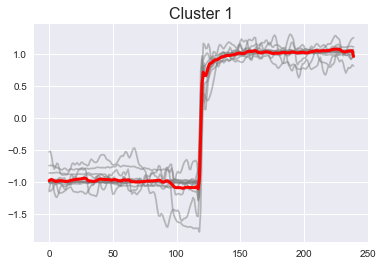

In [15]:
plt.figure(); 
## Get elements in cluster 1
els = clusters[0][1]
for el in els:
    plt.plot(batch[el, :], color='gray', alpha=0.5)

## Get centroid of cluster 1
centroid1 = clusters[0][0]
plt.plot(centroid1, color='red', linewidth=3)

plt.title('Cluster 1', fontsize=16);

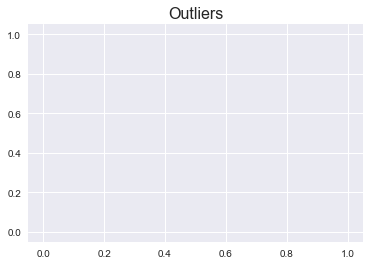

In [16]:
plt.figure(); 
## Get outliers
els = clusters[-1]
for el in els:
    plt.plot(batch[el, :], color='gray', alpha=0.5)

plt.title('Outliers', fontsize=16);